In [1]:
import modules.resnet_3d as resnet
from pathlib import Path
import numpy as np
from modules.mapper import FileMapper as fm
from modules.dataset import Dataset
from modules.dataset_image_only import Dataset as dataset_2
from modules.cnn_model import CNNModel
from torch.utils.data import DataLoader
import torchtuples as tt
from pycox.models import LogisticHazard
import pickle
import random
from modules.mlflow_logger import Logger
from modules.utils import getPatientIdentifier, collate_fn, returnMontage, get_optimizer
import sys
import argparse
import datetime
from pycox.evaluation import EvalSurv
from pycox.utils import kaplan_meier
import logging
import logging.config
import pytz
import torch
import plotly.graph_objs as go
# from lifelines import KaplanMeierFitter
import plotly
plotly.offline.init_notebook_mode(connected=True)
import pandas as pd
%load_ext autoreload
%autoreload 2

# Create Dataset

In [2]:
preop_patients = []
for path in Path('./data/preoperative_no_norm').glob('BMIAXNA*'):
    preop_patients.append(path)

In [3]:
id_mapping = './data/pickles_jsons/id_surv_mapping_10_groups.json'

In [4]:
mapper_class = fm(preop_patients, id_mapping, normalized=True)
dataset = mapper_class.generate_mapping()

Number of patients/folders: 1016


In [5]:
with open('./data/pickles_jsons/filter_ids_v2_all.pkl', 'rb') as file:
    filter_ids = pickle.load(file)
dataset_filtered = [entry for entry in dataset if entry['ENT'] is not None]
dataset_filtered = [entry for entry in dataset_filtered if entry['id'] not in filter_ids]

## Set Random seed and randomize dataset

In [6]:
random.seed(4)
random.shuffle(dataset_filtered)

In [7]:
dataset_filtered[0]

{'id': 'BMIAXNAT_S09999',
 'T2w': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S09999/T2w/BMIAXNAT_E99999_301_T2w.nii.gz',
 'T1c': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S09999/T1c/BMIAXNAT_E99999_301_T1c.nii.gz',
 'T1w': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S09999/T1w/BMIAXNAT_E99999_301_T1w.nii.gz',
 'ENT': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S09999/ENT/BMIAXNAT_E99999_302-MR1_ENT.nii.gz',
 'FLR': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S09999/FLR/BMIAXNAT_E99999_301_FLR.nii.gz',
 'surv': 45.0,
 'event': 1,
 'group': 1}

# Train/Test/Val split datasets

In [7]:
train_dataset = Dataset(dataset_filtered, phase='train', normalize='zscore', size=64)
val_dataset = Dataset(dataset_filtered, phase='val', normalize='zscore', size=64)

Training Size: 711
Validation Size: 101


In [8]:
test_dataset = dataset_2(dataset_filtered, phase='test', normalize='zscore', size=64)

Test Size: 204


# DataLoaders

In [9]:
train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          num_workers=6,
                          shuffle=False,
                          collate_fn=collate_fn)
val_loader = DataLoader(val_dataset,
                        batch_size=128,
                        num_workers=6, shuffle=False,
                        collate_fn=collate_fn)
test_loader = DataLoader(test_dataset,
                         batch_size=204,
                         shuffle=False)

# ResNet-10

In [10]:
cuts = np.array([   0.,   66.,  141.,  208.,  292.,  363.,  449.,  592.,  829., 1785.])

In [11]:
net = resnet.generate_model(model_depth=10,
                        n_classes=10,
                        n_input_channels=4,
                        shortcut_type='B',
                        conv1_t_size=7,
                        conv1_t_stride=1,
                        no_max_pool=False,
                        widen_factor=1.0)

# Model

In [12]:
model = LogisticHazard(net, tt.optim.AdamWR(), duration_index=cuts, device=0)

### Load model weights (if wanted)

In [14]:
model.load_model_weights('./Results/best_zscore/Resnet_12-10.pt')

### Load validation losses (for plotting)

In [15]:
with open('./Results/best_zscore/best_zscore.pk', 'rb') as file:
    smallest_loss = pickle.load(file).cpu().detach().numpy()

### Train model (if wanted)

In [ ]:
log = model.fit_dataloader(train_loader, num_epochs, [tt.cb.EarlyStopping(patience=5)], True, val_dataloader=val_loader)

# Validation Loss spread

## ResNet

In [16]:
trace = go.Scatter(x=list(range(len(smallest_loss))), y=smallest_loss, mode='markers', name='Subject loss', line_color='blue')
layout = go.Layout(
                   xaxis_range=(-0.5, 102), 
                   xaxis_tickmode = 'linear', 
                   xaxis_dtick = 5, 
                   xaxis_title='Subject', 
                   yaxis_title='Negative Log Likelihood',
                   plot_bgcolor='rgb(252, 253, 255)', 
                   xaxis_gridcolor='rgb(245, 242, 240)',
                   yaxis_gridcolor='rgb(245, 242, 240)',
                   yaxis_linecolor="black",
                   xaxis_linecolor="black",
                   yaxis_range=(-0.5, 7),
                   yaxis_tickmode = 'linear',
                   yaxis_dtick = 0.5,    
                   showlegend=True,
                   legend_yanchor="top",
                   legend_y = 0.99,
                   legend_xanchor="right",
                   legend_x=0.99,
                   width=500,height=500, autosize=False)
trace2 = go.Scatter(x=list(range(len(smallest_loss))), y=[smallest_loss.mean()]*len(smallest_loss), name='Mean Loss', line_color='red')
fig = go.Figure([trace, trace2], layout=layout)

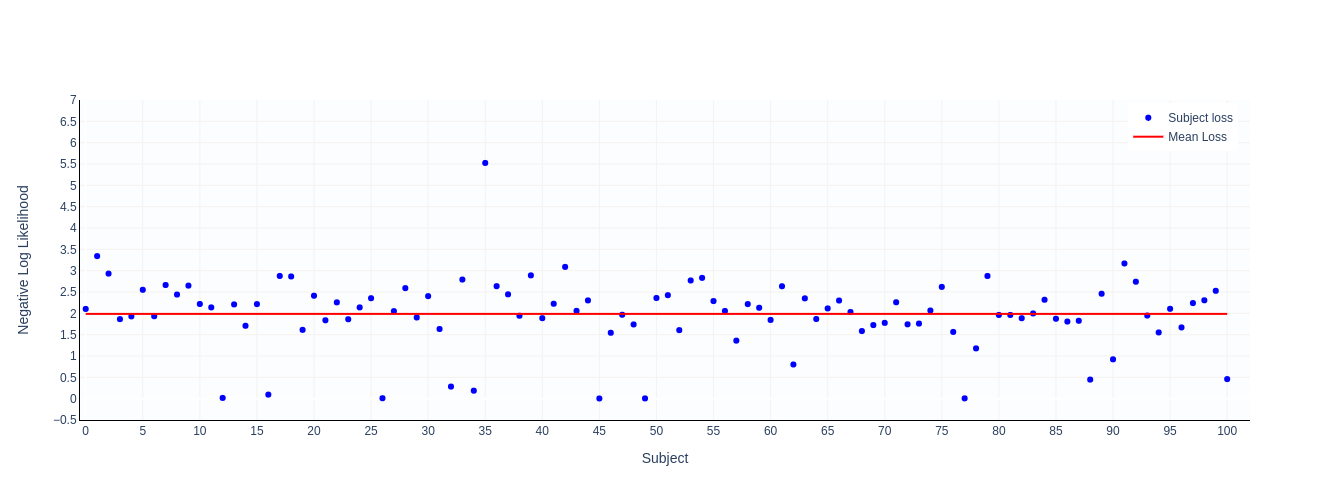

In [17]:
fig

## MLP

In [145]:
with open('./Results/loss/best_clinical_13-10.pk', 'rb') as file:
    data = pickle.load(file).cpu().detach().numpy()

In [19]:
trace = go.Scatter(x=list(range(len(smallest_loss))), y=data, mode='markers', name='Subject loss', line_color='blue')
trace2 = go.Scatter(x=list(range(len(smallest_loss))), y=[data.mean()]*len(smallest_loss), name='Mean Loss', line_color='red')
fig = go.Figure([trace, trace2], layout=layout)

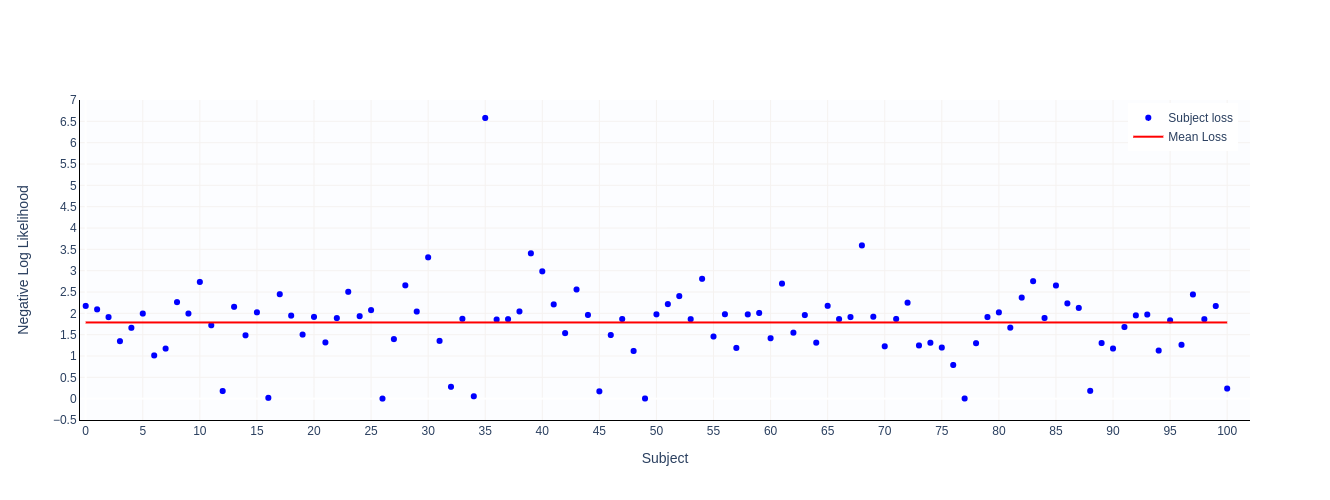

In [20]:
fig

# MLP without Age

In [21]:
with open('./Results/loss/loss-2020-10-15_12-37.pk', 'rb') as file:
    data = pickle.load(file).cpu().detach().numpy()

In [22]:
trace = go.Scatter(x=list(range(len(smallest_loss))), y=data, mode='markers', name='Subject loss', line_color='blue')
trace2 = go.Scatter(x=list(range(len(smallest_loss))), y=[data.mean()]*len(smallest_loss), name='Mean Loss', line_color='red')
fig = go.Figure([trace, trace2], layout=layout)

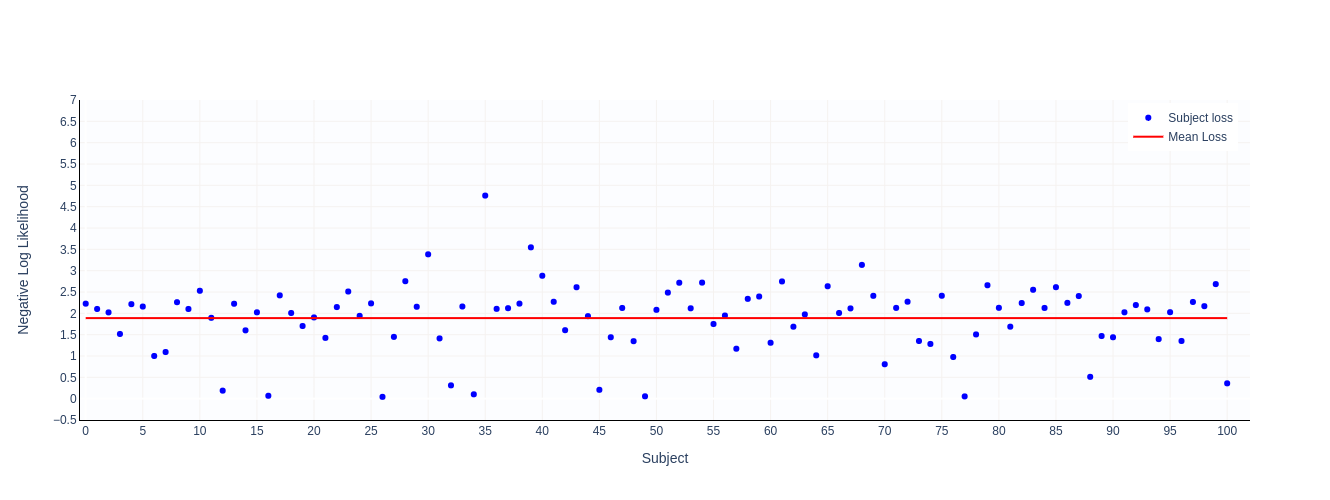

In [23]:
fig

In [149]:
mapping = {loss: idx for idx, loss in list(enumerate(smallest_loss))}

In [151]:
[mapping[x] for x in sorted(smallest_loss)][0:10]

[45, 49, 77, 26, 12, 16, 34, 32, 88, 100]

# Validation per group

In [97]:
val_data = dataset_filtered[int(len(dataset_filtered) * 0.7):int(len(dataset_filtered) * 0.8)]

## MRI

In [98]:
dict_group_val = {}

for i, entry in enumerate(val_data):
    empty_list = []
    group = entry['group']
    loss = smallest_loss[i]
    if group not in dict_group_val.keys():
        empty_list.append(loss)
        dict_group_val[group] = empty_list
    else:
        dict_group_val[group].append(loss)

In [99]:
list_means_loss = []
for group in sorted(dict_group_val.items()):
    nr = group[0]
    loss_list = np.array(group[1])
    mean_loss = loss_list.mean()
    list_means_loss.append(mean_loss)

## Clinical

In [100]:
dict_group_val_clinical = {}

for i, entry in enumerate(val_data):
    empty_list = []
    group = entry['group']
    loss = data[i]
    if group not in dict_group_val_clinical.keys():
        empty_list.append(loss)
        dict_group_val_clinical[group] = empty_list
    else:
        dict_group_val_clinical[group].append(loss)

In [101]:
list_means_loss_clinical = []
for group in sorted(dict_group_val_clinical.items()):
    nr = group[0]
    loss_list = np.array(group[1])
    mean_loss = loss_list.mean()
    list_means_loss_clinical.append(mean_loss)

In [128]:
cuts

array([   0.,   66.,  141.,  208.,  292.,  363.,  449.,  592.,  829.,
       1785.])

In [132]:
trace = go.Scatter(x=cuts, y=list_means_loss, mode='markers', name='3D ResNet', line_color='blue')
layout = go.Layout(
                   xaxis_range=(-1, 850),
    xaxis_tickvals=cuts,
    
#                    xaxis_tickmode = 'linear', 
#                    xaxis_dtick = 1, 
                   xaxis_title='Discrete-time point', 
                   yaxis_title='Negative Log Likelihood',
                   plot_bgcolor='rgb(252, 253, 255)', 
                   xaxis_gridcolor='rgb(245, 242, 240)',
                   yaxis_gridcolor='rgb(245, 242, 240)',
                   yaxis_linecolor="black",
                   xaxis_linecolor="black",
                   yaxis_range=(-0.5, 3.5),
                   yaxis_tickmode = 'linear',
                   yaxis_dtick = 0.5,    
                   showlegend=True,
                   legend_yanchor="top",
                   legend_y = 0.2,
                   legend_xanchor="right",
                   legend_x=0.99,
                   width=500,height=500, autosize=False)
# trace2 = go.Scatter(x=cuts, y=[data.mean()]*len(smallest_loss), name='Mean Loss', line_color='red')
trace3 = go.Scatter(x=cuts, y=list_means_loss_clinical, mode='markers', name='FCNN', line_color='green')
fig = go.Figure([trace, trace3], layout=layout)

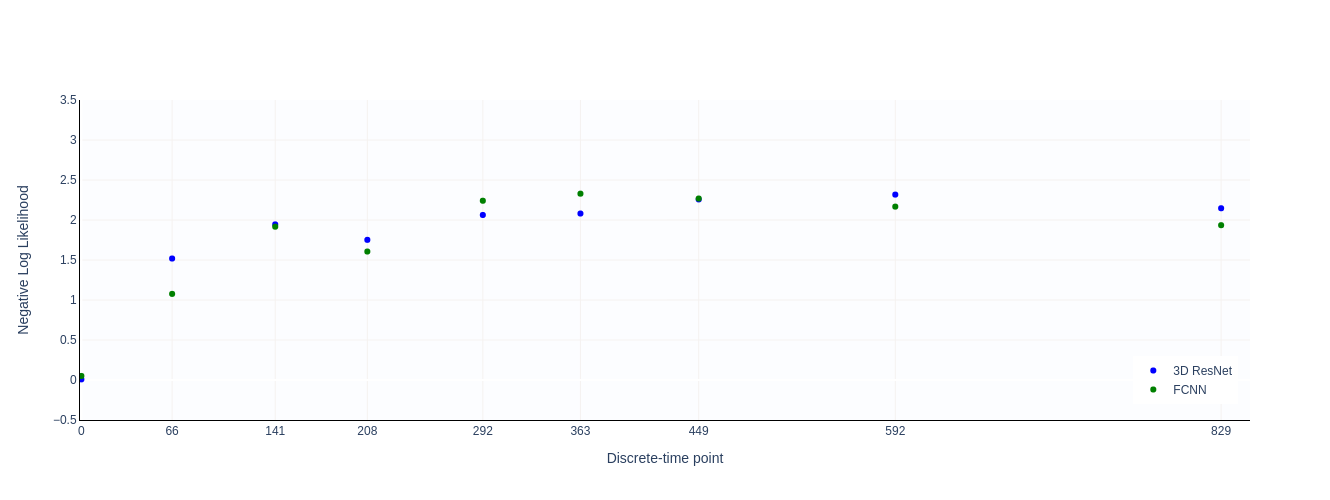

In [133]:
fig

# Test predictions

## Survival

In [16]:
predictions = model.predict_surv_df(test_loader)

### Interpolated

In [ ]:
predictions_interpolated = model.interpolate(10, 'const_hazard').predict_surv_df(test_loader)

### One patient example

In [17]:
trace = go.Scatter(x=predictions.iloc[:, 3].index.tolist(), y=predictions.iloc[:, 3].values.tolist(), mode='lines', line_shape='hv', name='Survival function', line_color='red')

layout = go.Layout(
#     title='Average survival curves per group', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t | x)', 
    plot_bgcolor='rgb(252, 252, 252)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 900),
    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,
    showlegend=True,
    legend_title='Discrete time',
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)
fig = go.Figure([trace], layout=layout)

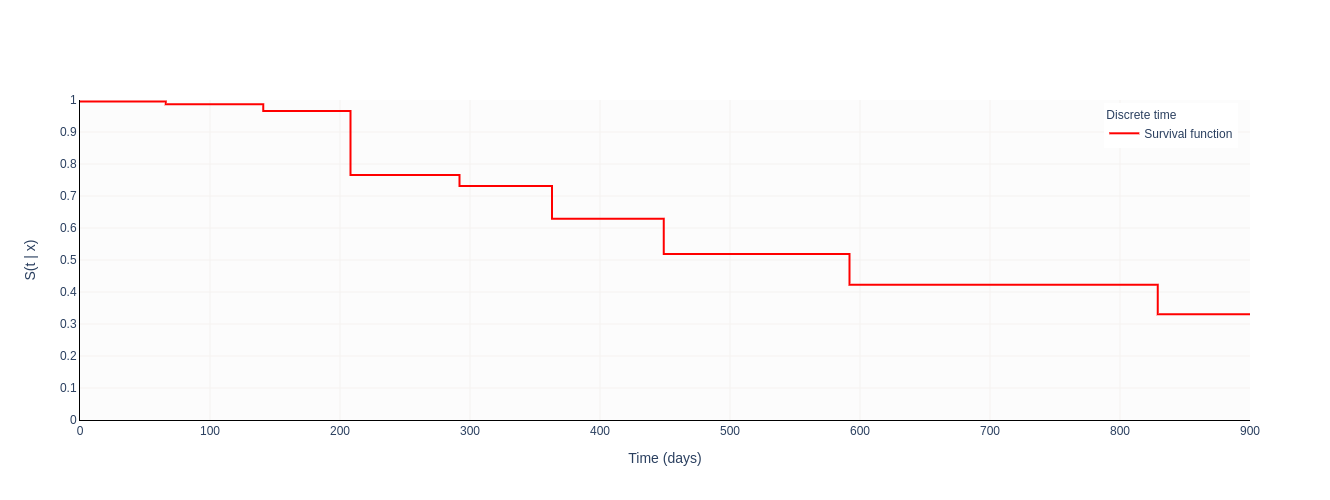

In [18]:
fig

# Calibration

In [19]:
km_test = pd.read_csv('./data/km_test.csv')

In [20]:
layout = go.Layout( 
    xaxis_title='Time (days)', 
    yaxis_title='S(t)', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 1800),
                
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,

    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)

In [21]:
trace1 = go.Scatter(x=predictions.mean(axis=1).index.tolist(), y=predictions.mean(axis=1).values.tolist(), mode='lines', line_shape='hv', name='Test sample predicted surv')
trace2 = go.Scatter(x=km_test['Unnamed: 0'].tolist(), y=km_test['0'].tolist(), name='Test sample observed surv')    

fig = go.Figure([trace1, trace2], layout=layout)

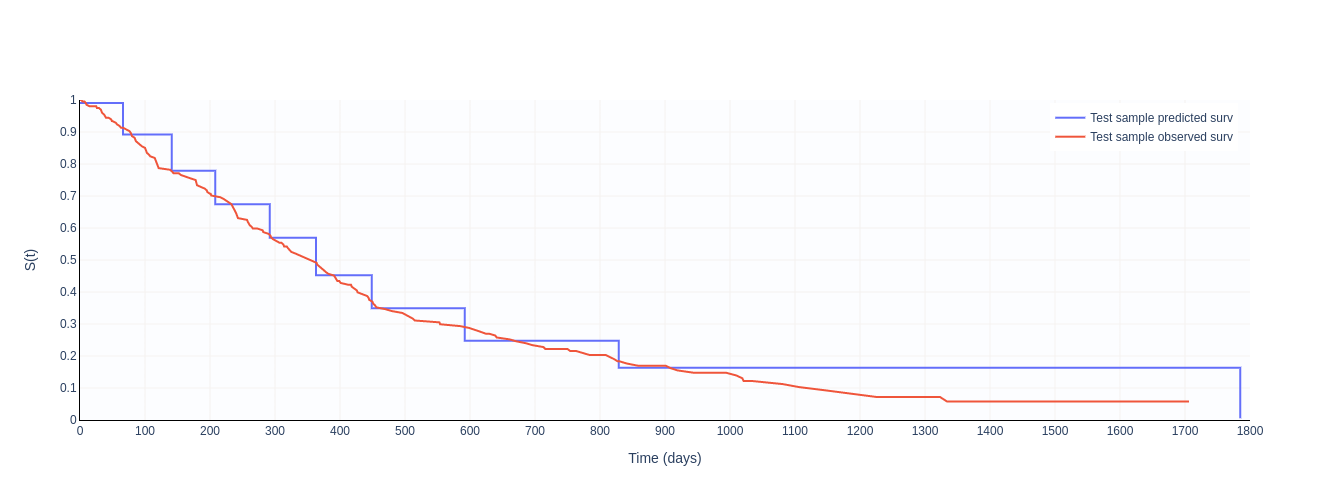

In [22]:
fig

## Interpolated

In [34]:
trace1 = go.Scatter(x=predictions_interpolated.mean(axis=1).index.tolist(), y=predictions_interpolated.mean(axis=1).values.tolist(), mode='lines', name='Test sample predicted surv')
trace2 = go.Scatter(x=km_test['Unnamed: 0'].tolist(), y=km_test['0'].tolist(), name='Test sample observed surv')    

fig = go.Figure([trace1, trace2], layout=layout)

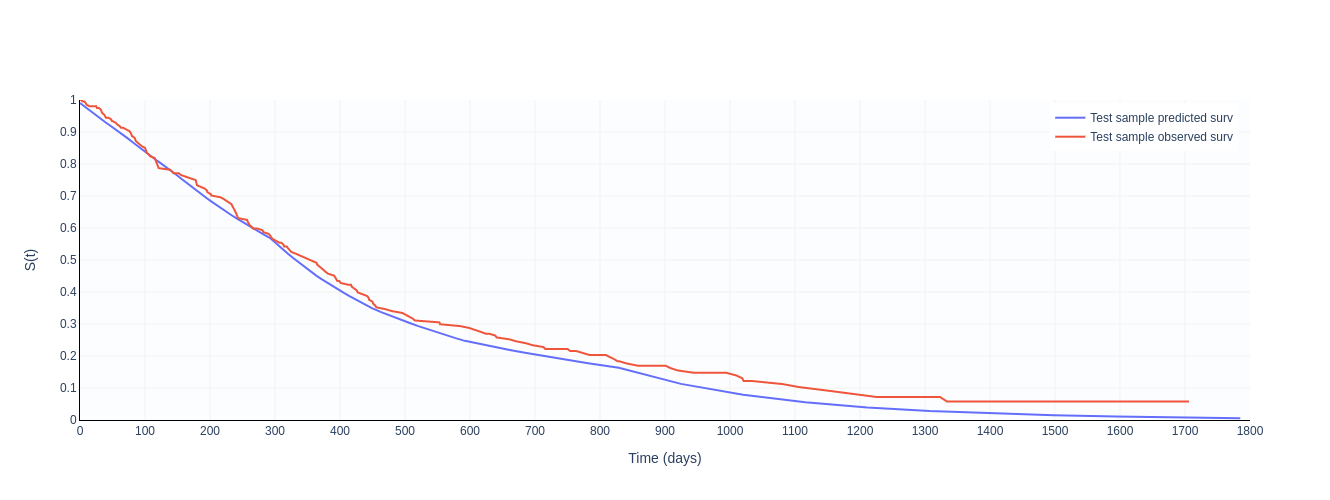

In [35]:
fig

## Hazard

In [199]:
# predictions_hazards = model.predict_hazard(test_loader)
# predictions_hazards_df = pd.DataFrame(predictions_hazards).T
# predictions_hazards_df.index = cuts

## Survival interpolated

In [200]:
# predictions_interpolated = model.interpolate(10).predict_surv_df(test_loader)

# Average survival curves

In [33]:
targets = dataset_2(dataset_filtered, phase='test', targets=True)[0][0]
events = dataset_2(dataset_filtered, phase='test', targets=True)[0][1]
survs = dataset_2(dataset_filtered, phase='test', targets=True)[0][2]

Test Size: 204
Test Size: 204
Test Size: 204


In [213]:
np.mean(survs)

400.8480392156863

In [90]:
predictions.head(2)

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0.0,0.990055,0.992006,0.987310,0.994929,0.98975,0.988385,0.990843,0.990330,0.989996,0.988631,...,0.990469,0.994382,0.988459,0.996097,0.988947,0.990163,0.994685,0.989106,0.988940,0.990191
66.0,0.858217,0.958616,0.805592,0.986619,0.89922,0.891499,0.930607,0.838157,0.900954,0.821394,...,0.838985,0.967176,0.858970,0.991538,0.832813,0.921720,0.963127,0.842578,0.825074,0.921662


In [77]:
predictions_non_censored = predictions.loc[:, events == 1]
targets_uncensored = targets[events == 1]
survs_uncensored = survs[events == 1]
events_uncensored = events[events == 1]

In [89]:
group_x = []
group_y = []
for i in range(10):
    idx = targets == i
    group_df = predictions.loc[:, idx].mean(axis=1).rename(i)
    group_x.append(list(group_df.index))
    group_y.append(group_df.values)

In [68]:
cuts

array([   0.,   66.,  141.,  208.,  292.,  363.,  449.,  592.,  829.,
       1785.])

In [205]:
labels = [ '0',   '66 - 141',  '141 - 208',  '208 - 292',  '292 - 363',  '363 - 449',  '449 - 592',  '592 - 829',  '829 - 1785', '1785']

In [252]:
# colors = ['rgb(166,206,227)','rgb(31,120,180)','rgb(178,223,138)','rgb(51,160,44)','rgb(251,154,153)','rgb(227,26,28)','rgb(253,191,111)','rgb(255,127,0)','rgb(202,178,214)','rgb(106,61,154)']
colors = ['rgb(103,0,31)','rgb(178,24,43)','rgb(214,96,77)','rgb(244,165,130)','rgb(253,219,199)','rgb(209,229,240)','rgb(146,197,222)','rgb(67,147,195)','rgb(33,102,172)','rgb(5,48,97)']
traces = []
for i in range(10):
    trace = go.Scatter(x=[group_x[i][1], group_x[i][4], group_x[i][5], group_x[i][6], group_x[i][7]], y=[group_y[i][1], group_y[i][4], group_y[i][5], group_y[i][6], group_y[i][7]], mode='markers', name='{} days'.format(int(cuts[i])), line_color=colors[i], line_width=1.5)
    traces.append(trace)

In [69]:
# colors = ['rgb(166,206,227)','rgb(31,120,180)','rgb(178,223,138)','rgb(51,160,44)','rgb(251,154,153)','rgb(227,26,28)','rgb(253,191,111)','rgb(255,127,0)','rgb(202,178,214)','rgb(106,61,154)']
colors = ['rgb(103,0,31)','rgb(178,24,43)','rgb(214,96,77)','rgb(244,165,130)','rgb(253,219,199)','rgb(209,229,240)','rgb(146,197,222)','rgb(67,147,195)','rgb(33,102,172)','rgb(5,48,97)']
traces = []
for i in range(9):
    trace = go.Scatter(x=group_x[i], y=group_y[i], mode='markers', name='{} days'.format(int(cuts[i])), line_color=colors[i], line_width=1.5)
    traces.append(trace)

In [73]:
fig = go.Figure(traces, layout=layout)
# fig.update_yaxes(type="log")

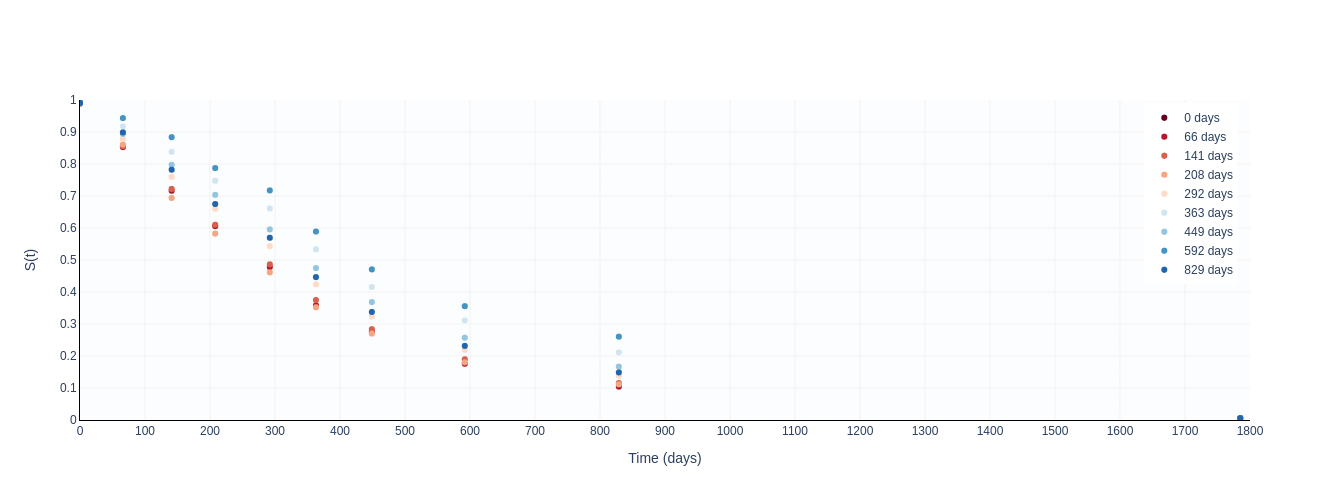

In [74]:
fig

## Average Hazard curves

In [ ]:
group_x_hazard = []
group_y_hazard = []
for i in range(10):
    idx = targets == i
    group_df = predictions_hazards.loc[:, idx].mean(axis=1).rename(i)
    group_x_hazard.append(list(group_df.index))
    group_y_hazard.append(group_df.values)

In [ ]:
traces = []
for i in range(10):
    trace = go.Scatter(x=group_x_hazard[i], y=group_y_hazard[i], line_shape='hv', mode='lines', name='group {}'.format(i), line_color=colors[i])
    traces.append(trace)
    
layout = go.Layout(layout = go.Layout(
#     title='Average survival curves per group', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='H(t | x)', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 1800),
    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)
fig = go.Figure(traces, layout=layout)

In [ ]:
fig

# Evaluate

## Discrete

In [34]:
survs = dataset_2(dataset_filtered, phase='test', targets=True)[0][2]

Test Size: 204


In [82]:
ev = EvalSurv(predictions, survs, events, 'km')

In [86]:
concordance = ev.concordance_td('antolini')
time_grid = np.linspace(0, survs.max())
# time_grid = np.linspace(0, 829)

integrated_brier_score = ev.integrated_brier_score(time_grid)

In [87]:
integrated_brier_score

0.13079057416231443

In [88]:
concordance

0.6206917402346112

In [57]:
brier_score = ev.brier_score(time_grid)

## Interpolated

In [39]:
ev_inter = EvalSurv(predictions_interpolated, survs, events, 'km')

In [40]:
concordance = ev_inter.concordance_td('antolini')
time_grid = np.linspace(0, survs.max())
integrated_brier_score = ev_inter.integrated_brier_score(time_grid)

In [41]:
integrated_brier_score

0.12749317839948826

In [42]:
concordance

0.6260128189623897

# Brier score clinical vs mri

In [44]:
layout = go.Layout( 
    xaxis_title='Time (days)', 
    yaxis_title='Brier score', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 1800),
                
    yaxis_range=(0, 0.26),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.05,

    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)

In [41]:
brier_score_clinical = pd.read_csv('./data/predictions/clinical_brier_score.csv')

In [47]:
trace = go.Scatter(x=brier_score.index.tolist(), y=brier_score.values, name='3D ResNet')
trace_clinical = go.Scatter(x=brier_score_clinical['Unnamed: 0'].tolist(), y=brier_score_clinical['brier_score'].tolist(), name='FCNN')
layout_brier = go.Layout(title='Brier score', 
                         title_x=0.5, xaxis_title='Time (days)', 
                         yaxis_title='Brier score',
                        plot_bgcolor='rgb(252, 253, 255)', 
                   xaxis_gridcolor='rgb(245, 242, 240)',
                  yaxis_gridcolor='rgb(245, 242, 240)',
                  yaxis_linecolor="black",
                  xaxis_linecolor="black",
                        xaxis_range=(0,1750),
                        xaxis_tickmode = 'linear',
        xaxis_dtick = 100)
fig_brier = go.Figure([trace, trace_clinical], layout=layout)

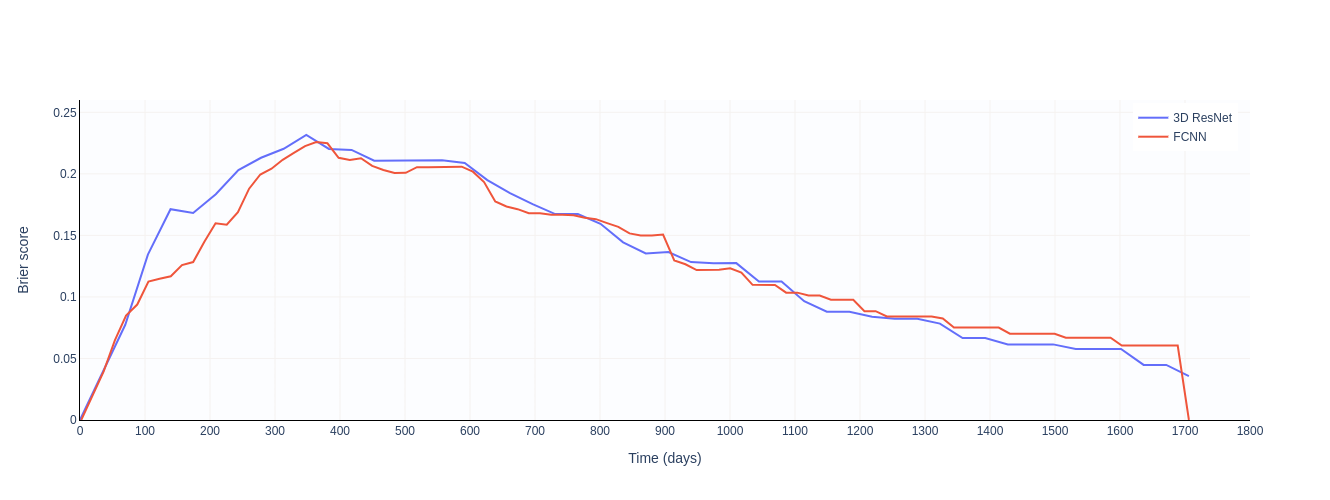

In [48]:
fig_brier